In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import tensorflow_probability as tfp  # For Bayesian Neural Network

# Load dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
tfd = tfp.distributions

In [57]:
print("TensorFlow version:", tf.__version__)
print("TensorFlow Probability version:", tfp.__version__)

TensorFlow version: 2.10.0
TensorFlow Probability version: 0.18.0


ANN

In [58]:
# Custom callback to track training, validation loss (ELBO), MSE, time per epoch, and accuracy
class LossHistory(keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val  # Validation data (features)
        self.y_val = y_val  # Validation data (labels)
        self.train_loss = []  # Track ELBO loss for training
        self.val_loss = []  # Track ELBO loss for validation
        self.val_accuracy = []  # Track accuracy on validation set
        self.epoch_times = []  # To track time per epoch
        self.start_time = None  # To track the overall training start time

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        # Store ELBO loss
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        self.train_loss.append(train_loss)
        self.val_loss.append(val_loss)

        # Compute validation accuracy
        y_pred = self.model.predict(self.X_val, verbose=0)
        logits_mean = y_pred[:, :self.y_val.shape[1]]
        y_pred_classes = tf.argmax(tf.nn.softmax(logits_mean), axis=1)
        y_true_classes = tf.argmax(self.y_val, axis=1)
        accuracy = tf.reduce_mean(tf.cast(y_pred_classes == y_true_classes, tf.float32))
        self.val_accuracy.append(accuracy)

        # Track epoch time
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)

        # Print losses, time, and accuracy
        print(f"Val Accuracy = {accuracy:.4f}")

    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        print(f"Training completed in {total_time:.2f} seconds")

def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, epochs=10, batch_size=128):
    # Initialize the custom LossHistory callback to track ELBO loss
    history = LossHistory(X_val, y_val)

    # Track the start time
    start_time = time.time()

    # Train the model with the callback
    model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[history]
    )

    # Track the end time
    end_time = time.time()

    # Return the trained model, the history object, and the total training time
    return model, history, end_time - start_time


In [59]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tfp.layers.DistributionLambda(
        lambda t: tfp.distributions.MultivariateNormalDiag(
            loc=tf.zeros(n), scale_diag=tf.constant(0.0316, shape=(n,))
        )
    )


def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return keras.Sequential([
        tfp.layers.VariableLayer(
            shape=(2 * n,),
            dtype=dtype,
            initializer=keras.initializers.Constant([0] * n + [-7.0] * n)
        ),
        tfp.layers.DistributionLambda(
            make_distribution_fn=lambda t: tfp.distributions.Independent(
                tfp.distributions.Normal(
                    loc=t[..., :n],
                    scale=tf.nn.softplus(t[..., n:])
                ),
                reinterpreted_batch_ndims=1
            )
        )
    ])

In [60]:
# Load the MNIST dataset
(X_train_full, y_train_full), (X_test_full, y_test_full) = mnist.load_data()

# Flatten and normalize
X_train_full = X_train_full.reshape(-1, 28 * 28).astype("float32") / 255.0
X_test_full = X_test_full.reshape(-1, 28 * 28).astype("float32") / 255.0

# Split test set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test_full, y_test_full, test_size=0.5, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# One-hot encode the labels
num_classes = 10
y_train_full = tf.one_hot(y_train_full, num_classes)
y_val = tf.one_hot(y_val, num_classes)
y_test = tf.one_hot(y_test, num_classes)

In [ ]:
# Define the regularized neural network
def build_regularized_nn(input_dim, num_classes):
    model = Sequential([
        Dense(64, activation="relu", kernel_regularizer=l2(0.001), input_dim=input_dim),
        Dropout(0.3),  # Dropout with 30% rate
        Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
        Dropout(0.3),  # Dropout with 30% rate
        Dense(num_classes, activation="softmax")
    ])
    return model

# Build the model
input_dim = X_train_full.shape[1]
model = build_regularized_nn(input_dim=input_dim, num_classes=num_classes)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model for 50 epochs
history = model.fit(
    X_train_full,
    y_train_full,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    verbose=1
)

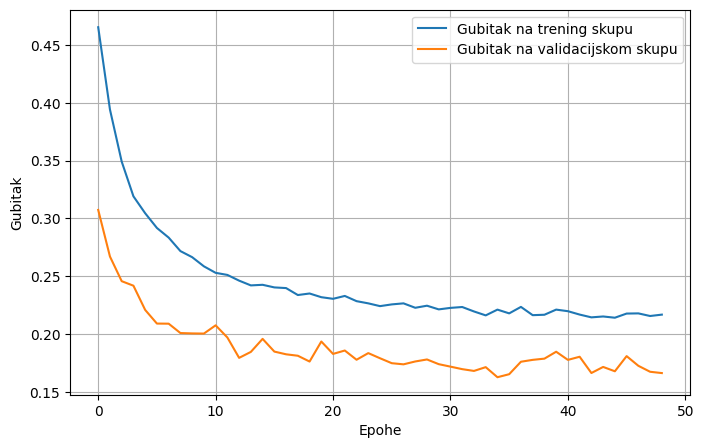

In [11]:
# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"][1:], label="Gubitak na trening skupu")
plt.plot(history.history["val_loss"][1:], label="Gubitak na validacijskom skupu")
plt.xlabel("Epohe")
plt.ylabel("Gubitak")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Overall Test Accuracy: {test_accuracy:.4f}")

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class predictions
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot labels to class indices

# Calculate accuracy for each class
class_accuracies = {}
for class_idx in range(num_classes):
    # Filter for samples belonging to the current class
    class_indices = np.where(y_true_classes == class_idx)[0]
    class_accuracy = accuracy_score(y_true_classes[class_indices], y_pred_classes[class_indices])
    class_accuracies[class_idx] = class_accuracy

# Display accuracy for each class
print("\nAccuracy for each class:")
for class_idx, accuracy in class_accuracies.items():
    print(f"Class {class_idx}: {accuracy:.4f}")

BNN

In [62]:
def create_bnn_model(input_dim, num_classes, train_size):
    kl_weight = 1 / train_size  # Scale KL divergence by training size
    inputs = keras.Input(shape=(input_dim,))  # Input layer

    # Add hidden layers with uncertainty using DenseVariational
    features = inputs
    for units in [64, 64]:  # Hidden layers with 64 units
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=kl_weight,
            activation="relu"
        )(features)

    # Final output layer predicts mean and log-variance for each class
    outputs = layers.Dense(units=2 * num_classes)(features)  # Outputs for value and log-variance

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Define the learning rate schedule
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.9
    )
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

    def nll_classification(y, y_pred):

        # Split predictions into logits mean and log-variance
        logits_mean = y_pred[:, :y.shape[1]]  # Predicted mean of logits
        logits_log_variance = y_pred[:, y.shape[1]:]  # Predicted log variance of logits

        # Convert log variance to variance
        logits_log_variance = tf.clip_by_value(logits_log_variance, -10, 10)
        logits_variance = tf.exp(logits_log_variance)
        logits_variance = tf.clip_by_value(logits_variance, 1e-8, 1e3)  # Klipanje varijance

        penalty = 0.01 * tf.reduce_mean(logits_log_variance ** 2) # Regularizacija za varijancu

        # Sample logits from the predicted distribution
        sampled_logits = logits_mean + tf.sqrt(logits_variance) * tf.random.normal(tf.shape(logits_mean))

        # Compute negative log-likelihood using sampled logits
        nll_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=sampled_logits)) + penalty
        return nll_loss

    # Compile the model with the optimizer using the learning rate schedule
    model.compile(
        optimizer=optimizer,
        loss=nll_classification
    )
    return model

In [63]:
train_size = X_train_full.shape[0]
input_dim = X_train_full.shape[1]

lr = 0.001
no_epochs = 50

bnn_model = create_bnn_model(input_dim=input_dim, num_classes=num_classes, train_size=train_size)
bnn_model, history, total_time = train_and_evaluate_model(bnn_model, X_train_full, y_train_full, X_val, y_val, epochs=no_epochs)

print(f"Training completed in {total_time:.2f} seconds.")

Epoch 1/50
469/469 [==============================] - 12s 18ms/step - loss: 3.1880 - val_loss: 2.7523
Epoch 2/50
469/469 [==============================] - 6s 13ms/step - loss: 2.5392 - val_loss: 2.3233
Epoch 3/50
469/469 [==============================] - 7s 14ms/step - loss: 2.1227 - val_loss: 1.9316
Epoch 4/50
469/469 [==============================] - 5s 12ms/step - loss: 1.7492 - val_loss: 1.5781
Epoch 5/50
469/469 [==============================] - 7s 15ms/step - loss: 1.4266 - val_loss: 1.2838
Epoch 6/50
469/469 [==============================] - 5s 11ms/step - loss: 1.1632 - val_loss: 1.0686
Epoch 7/50
469/469 [==============================] - 8s 16ms/step - loss: 0.9597 - val_loss: 0.8830
Epoch 8/50
469/469 [==============================] - 5s 11ms/step - loss: 0.8190 - val_loss: 0.7744
Epoch 9/50
469/469 [==============================] - 6s 13ms/step - loss: 0.7182 - val_loss: 0.6868
Epoch 10/50
469/469 [==============================] - 6s 13ms/step - loss: 0.6545 - val_l

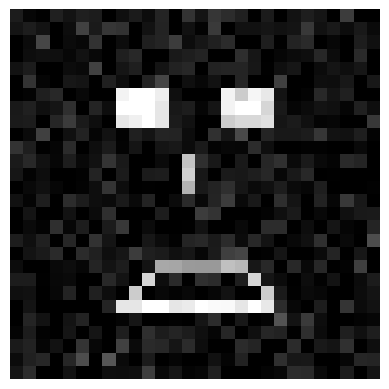

Smiley vector shape: (784,)


In [69]:
import numpy as np
import matplotlib.pyplot as plt

smiley_face = np.random.normal(loc=0.05, scale=0.09, size=(28, 28))
smiley_face = np.clip(smiley_face, 0, 1)

smiley_face[6:9, 8:12] += 0.9
smiley_face[7, 9:11] += 0.6
smiley_face[6:9, 16:20] += 0.8
smiley_face[7, 17:19] += 0.6

smiley_face[11:14, 13] += 0.7

smiley_face[22, 8:20] += 0.9
smiley_face[21, 9] += 0.8
smiley_face[21, 19] += 0.8
smiley_face[20, 10] += 0.7
smiley_face[20, 18] += 0.7
smiley_face[19, 11:18] += 0.6

smiley_face = np.clip(smiley_face, 0, 1)

plt.imshow(smiley_face, cmap="gray")
plt.axis("off")
plt.show()

smiley_vector = smiley_face.flatten()

print("Smiley vector shape:", smiley_vector.shape)


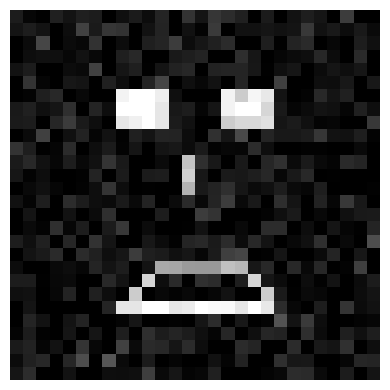

BNN Prediction: 5
ANN Prediction: 5

BNN Probabilities:
  Class 0: 0.013366
  Class 1: 0.047867
  Class 2: 0.115437
  Class 3: 0.051954
  Class 4: 0.005965
  Class 5: 0.622175
  Class 6: 0.064878
  Class 7: 0.067507
  Class 8: 0.003333
  Class 9: 0.007519

ANN Probabilities:
  Class 0: 0.008408
  Class 1: 0.076730
  Class 2: 0.091563
  Class 3: 0.054800
  Class 4: 0.026248
  Class 5: 0.548388
  Class 6: 0.016886
  Class 7: 0.165370
  Class 8: 0.005370
  Class 9: 0.006238

BNN Epistemic Uncertainty: 0.197349
BNN Aleatoric Uncertainty: 0.225143
BNN Total Uncertainty: 0.299393


In [70]:
def predict_custom_image_with_bnn_and_nn(smiley_face, bnn_model, nn_model, scaler, num_classes):
    # Flatten and normalize the custom image
    smiley_flat = smiley_face.flatten().astype("float32") / 255.0  # Normalize to [0, 1]

    # Standardize the image using the provided scaler
    smiley_flat = scaler.transform(smiley_flat.reshape(1, -1))

    # Get BNN predictions
    num_samples = 100
    bnn_outputs = np.zeros((num_samples, num_classes))
    bnn_uncertainties = np.zeros((num_samples, num_classes))
    for i in range(num_samples):
        predictions = bnn_model(smiley_flat, training=True).numpy()
        logits = predictions[:, :num_classes]
        log_variance = predictions[:, num_classes:]
        probs = softmax(logits)
        uncertainties = transform_log_variance_to_std(log_variance, probs)
        bnn_outputs[i] = probs
        bnn_uncertainties[i] = uncertainties

    # Compute mean probabilities and uncertainties
    mean_bnn_probs = np.mean(bnn_outputs, axis=0)
    epistemic_uncertainty = np.std(bnn_outputs, axis=0)
    aleatoric_uncertainty = np.sqrt(np.mean(bnn_uncertainties**2, axis=0))
    total_uncertainty = np.sqrt(epistemic_uncertainty**2 + aleatoric_uncertainty**2)

    # Get ANN predictions
    nn_probs = nn_model.predict(smiley_flat, verbose=0)[0]

    # Get predicted classes
    bnn_pred_class = np.argmax(mean_bnn_probs)
    nn_pred_class = np.argmax(nn_probs)

    # Plot the custom image
    plt.figure(figsize=(4, 4))
    plt.imshow(smiley_face, cmap="gray")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Print predictions and details
    print(f"BNN Prediction: {bnn_pred_class}")
    print(f"ANN Prediction: {nn_pred_class}")
    print("\nBNN Probabilities:")
    for i, prob in enumerate(mean_bnn_probs):
        print(f"  Class {i}: {prob:.6f}")
    print("\nANN Probabilities:")
    for i, prob in enumerate(nn_probs):
        print(f"  Class {i}: {prob:.6f}")
    print(f"\nBNN Epistemic Uncertainty: {epistemic_uncertainty[bnn_pred_class]:.6f}")
    print(f"BNN Aleatoric Uncertainty: {aleatoric_uncertainty[bnn_pred_class]:.6f}")
    print(f"BNN Total Uncertainty: {total_uncertainty[bnn_pred_class]:.6f}")

# Call the function
predict_custom_image_with_bnn_and_nn(smiley_face, bnn_model, model, scaler, num_classes)


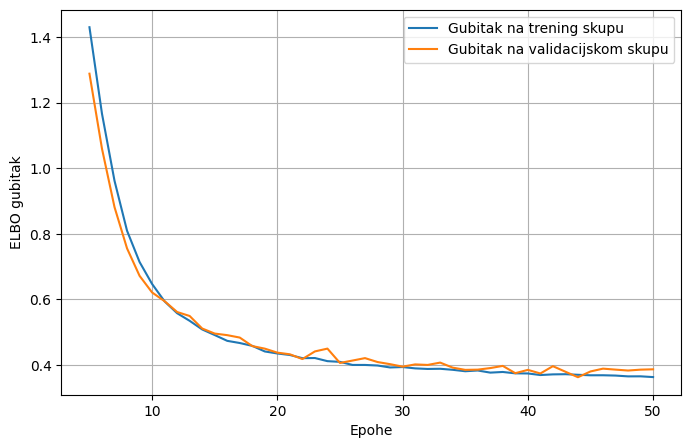

In [22]:
no_epochs = 50

train_elbo_loss = history.train_loss
val_elbo_loss = history.val_loss

plt.figure(figsize=(8, 5))
plt.plot(range(5, no_epochs + 1), train_elbo_loss[4:], label="Gubitak na trening skupu")
plt.plot(range(5, no_epochs + 1), val_elbo_loss[4:], label="Gubitak na validacijskom skupu")
plt.xlabel("Epohe")
plt.ylabel("ELBO gubitak")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
def evaluate_bnn(bnn_model, X_test, y_test, num_classes, num_samples=100):
    # Convert true labels to class indices
    y_true_classes = np.argmax(y_test, axis=1)

    # Perform Bayesian sampling
    sampled_predictions = np.zeros((num_samples, X_test.shape[0], num_classes))
    for i in range(num_samples):
        sampled_predictions[i] = bnn_model(X_test, training=True).numpy()[:, :num_classes]

    # Average the predictions across samples (mean probability)
    mean_predictions = np.mean(sampled_predictions, axis=0)

    # Predicted classes based on mean probabilities
    y_pred_classes = np.argmax(mean_predictions, axis=1)

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_true_classes, y_pred_classes)

    # Calculate accuracy for each class
    class_accuracies = {}
    for class_idx in range(num_classes):
        # Filter for samples belonging to the current class
        class_indices = np.where(y_true_classes == class_idx)[0]
        class_accuracy = accuracy_score(y_true_classes[class_indices], y_pred_classes[class_indices])
        class_accuracies[class_idx] = class_accuracy

    return overall_accuracy, class_accuracies

# Evaluate the BNN
overall_accuracy, class_accuracies = evaluate_bnn(bnn_model, X_test, y_test, num_classes)

# Print overall accuracy
print(f"Overall Test Accuracy: {overall_accuracy:.4%}")

# Print accuracy for each class
print("\nAccuracy for each class:")
for class_idx, accuracy in class_accuracies.items():
    print(f"Class {class_idx}: {accuracy:.4%}")


Overall Test Accuracy: 96.5000%

Accuracy for each class:
Class 0: 98.5830%
Class 1: 98.0392%
Class 2: 97.5191%
Class 3: 96.9407%
Class 4: 94.2116%
Class 5: 94.4578%
Class 6: 96.9636%
Class 7: 97.9839%
Class 8: 95.2083%
Class 9: 94.5312%


In [23]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stability trick
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def transform_log_variance_to_std(log_variance, softmax_probs):
    # Clip log_variance to prevent overflow
    log_variance = np.clip(log_variance, -10, 5)
    # Compute variance and clip again to prevent invalid values
    variance = np.exp(log_variance)
    variance = np.clip(variance, 1e-8, 1e3)
    # Transform variance to softmax space
    softmax_variance = variance * softmax_probs * (1 - softmax_probs)
    return np.sqrt(softmax_variance)

def predict_bnn_with_uncertainties(bnn_model, X_test, y_test, num_samples=100):
    num_classes = y_test.shape[1]
    num_instances = X_test.shape[0]

    # Containers for storing results
    sampled_probabilities = np.zeros((num_samples, num_instances, num_classes))
    sampled_uncertainties = np.zeros((num_samples, num_instances, num_classes))

    # Perform sampling
    for i in range(num_samples):
        # Predict using BNN (mean and log_variance for each class)
        predictions = bnn_model(X_test, training=True).numpy()
        means = predictions[:, :num_classes]
        log_variances = predictions[:, num_classes:]

        # Apply softmax to means to get class probabilities
        probs = softmax(means)

        # Transform log variance to standard deviation in the probability space
        std_probs = transform_log_variance_to_std(log_variances, probs)

        # Store results
        sampled_probabilities[i] = probs
        sampled_uncertainties[i] = std_probs

    # Aggregate results
    mean_probabilities = np.mean(sampled_probabilities, axis=0)
    epistemic_uncertainity = np.std(sampled_probabilities, axis=0)  # From sampling
    aleatoric_uncertainity = np.sqrt(np.mean(sampled_uncertainties ** 2, axis=0))  # From log variance

    # Calculate accuracy
    y_pred_classes = np.argmax(mean_probabilities, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    accuracy = np.mean(y_pred_classes == y_true_classes)

    # Return all results including predicted classes
    return {
        "mean_probabilities": mean_probabilities,
        "epistemic_uncertainity": epistemic_uncertainity,
        "aleatoric_uncertainity": aleatoric_uncertainity,
        "predicted_classes": y_pred_classes,  # Added predicted classes
        "accuracy": accuracy,
    }

In [24]:
results_bnn = predict_bnn_with_uncertainties(bnn_model, X_test, y_test, num_samples=100)

results_ann = {
    "predicted_classes": np.argmax(model.predict(X_test), axis=1),
    "mean_probabilities": model.predict(X_test)
}

157/157 [==============================] - 0s 2ms/step


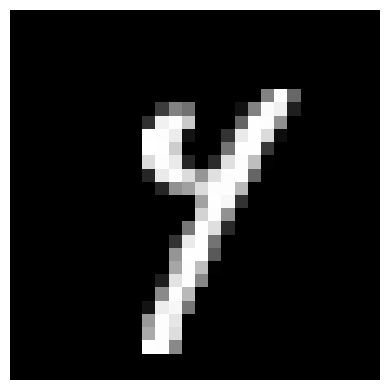

True Class: 4
BNN Prediction: 7
ANN Prediction: 4

BNN Probabilities:
  Class 0: 0.000144
  Class 1: 0.051033
  Class 2: 0.000131
  Class 3: 0.001648
  Class 4: 0.278688
  Class 5: 0.009047
  Class 6: 0.000101
  Class 7: 0.404747
  Class 8: 0.089608
  Class 9: 0.164852

ANN Probabilities:
  Class 0: 0.000034
  Class 1: 0.004171
  Class 2: 0.000122
  Class 3: 0.000597
  Class 4: 0.858549
  Class 5: 0.000433
  Class 6: 0.000013
  Class 7: 0.046641
  Class 8: 0.006306
  Class 9: 0.083134

BNN Epistemic Uncertainty: 0.240167
BNN Aleatoric Uncertainty: 0.246308
BNN Total Uncertainty: 0.344018


In [55]:
def plot_random_incorrect_example_with_details(results_bnn, results_ann, X_test, y_test, scaler):
    """
    Plot one randomly selected incorrect classification with details below the image.

    Parameters:
        results_bnn: Dictionary containing results from the Bayesian Neural Network.
        results_ann: Dictionary containing results from the classical neural network.
        X_test: Test set features.
        y_test: One-hot encoded test set labels.
        scaler: Scaler used to normalize the images, for inverse scaling.
    """
    # Extract data from the BNN results
    predicted_classes_bnn = results_bnn["predicted_classes"]
    epistemic_uncertainty = results_bnn["epistemic_uncertainity"]
    aleatoric_uncertainty = results_bnn["aleatoric_uncertainity"]
    mean_probabilities_bnn = results_bnn["mean_probabilities"]

    # Extract data from the ANN results
    predicted_classes_ann = results_ann["predicted_classes"]
    mean_probabilities_ann = results_ann["mean_probabilities"]

    # Convert true labels to class indices
    true_classes = np.argmax(y_test, axis=1)

    # Find incorrect indices
    incorrect_indices = np.where(predicted_classes_bnn != true_classes)[0]

    # Check if there are any incorrect examples
    if len(incorrect_indices) == 0:
        print("No incorrect examples found.")
        return

    # Randomly select one incorrect example
    incorrect_idx = np.random.choice(incorrect_indices, size=1)[0]

    # Inverse scale the image
    incorrect_image = scaler.inverse_transform(X_test[incorrect_idx].reshape(1, -1)).reshape(28, 28)

    # Get details for the selected example
    true_class = true_classes[incorrect_idx]
    pred_class_bnn = predicted_classes_bnn[incorrect_idx]
    pred_class_ann = predicted_classes_ann[incorrect_idx]
    probabilities_bnn = mean_probabilities_bnn[incorrect_idx]
    probabilities_ann = mean_probabilities_ann[incorrect_idx]
    epistemic_uncert = epistemic_uncertainty[incorrect_idx, pred_class_bnn]
    aleatoric_uncert = aleatoric_uncertainty[incorrect_idx, pred_class_bnn]
    total_uncertainty = np.sqrt(epistemic_uncert**2 + aleatoric_uncert**2)

    # Plot the incorrect example
    plt.figure(figsize=(4, 4))
    plt.imshow(incorrect_image, cmap="gray")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Print details below the image
    print(f"True Class: {true_class}")
    print(f"BNN Prediction: {pred_class_bnn}")
    print(f"ANN Prediction: {pred_class_ann}")
    print("\nBNN Probabilities:")
    for i, prob in enumerate(probabilities_bnn):
        print(f"  Class {i}: {prob:.6f}")
    print("\nANN Probabilities:")
    for i, prob in enumerate(probabilities_ann):
        print(f"  Class {i}: {prob:.6f}")
    print(f"\nBNN Epistemic Uncertainty: {epistemic_uncert:.6f}")
    print(f"BNN Aleatoric Uncertainty: {aleatoric_uncert:.6f}")
    print(f"BNN Total Uncertainty: {total_uncertainty:.6f}")

plot_random_incorrect_example_with_details(results_bnn, results_ann, X_test, y_test, scaler)

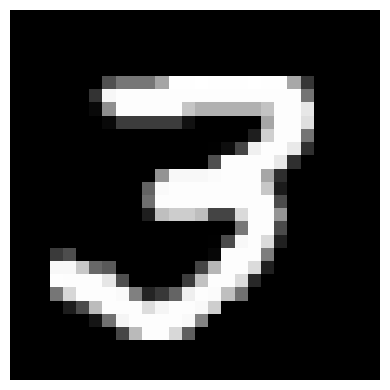

True Class: 3
BNN Prediction: 3
ANN Prediction: 3

BNN Probabilities:
  Class 0: 0.000000
  Class 1: 0.000000
  Class 2: 0.000002
  Class 3: 0.999995
  Class 4: 0.000000
  Class 5: 0.000000
  Class 6: 0.000000
  Class 7: 0.000000
  Class 8: 0.000001
  Class 9: 0.000000

ANN Probabilities:
  Class 0: 0.000000
  Class 1: 0.000000
  Class 2: 0.000000
  Class 3: 1.000000
  Class 4: 0.000000
  Class 5: 0.000000
  Class 6: 0.000000
  Class 7: 0.000000
  Class 8: 0.000000
  Class 9: 0.000000

BNN Epistemic Uncertainty: 0.000013
BNN Aleatoric Uncertainty: 0.000775
BNN Total Uncertainty: 0.000775


In [31]:
def plot_second_highest_probability_correct_example_with_details(results_bnn, results_ann, X_test, y_test, scaler):
    """
    Plot the correct classification where the BNN has the second-highest probability for the true class.

    Parameters:
        results_bnn: Dictionary containing results from the Bayesian Neural Network.
        results_ann: Dictionary containing results from the classical neural network.
        X_test: Test set features.
        y_test: One-hot encoded test set labels.
        scaler: Scaler used to normalize the images, for inverse scaling.
    """
    # Extract data from the BNN results
    predicted_classes_bnn = results_bnn["predicted_classes"]
    mean_probabilities_bnn = results_bnn["mean_probabilities"]
    epistemic_uncertainty = results_bnn["epistemic_uncertainity"]
    aleatoric_uncertainty = results_bnn["aleatoric_uncertainity"]

    # Extract data from the ANN results
    predicted_classes_ann = results_ann["predicted_classes"]
    mean_probabilities_ann = results_ann["mean_probabilities"]

    # Convert true labels to class indices
    true_classes = np.argmax(y_test, axis=1)

    # Find correct indices
    correct_indices = np.where(predicted_classes_bnn == true_classes)[0]

    # Check if there are any correct examples
    if len(correct_indices) == 0:
        print("No correct examples found.")
        return

    # Find the correct example with the second-highest probability for the true class
    correct_probabilities = mean_probabilities_bnn[correct_indices, true_classes[correct_indices]]
    sorted_indices = np.argsort(correct_probabilities)[::-1]  # Sort in descending order
    second_highest_prob_idx = correct_indices[sorted_indices[3]]  # Take the second highest

    # Inverse scale the image
    second_highest_prob_image = scaler.inverse_transform(X_test[second_highest_prob_idx].reshape(1, -1)).reshape(28, 28)

    # Get details for the selected example
    true_class = true_classes[second_highest_prob_idx]
    pred_class_bnn = predicted_classes_bnn[second_highest_prob_idx]
    pred_class_ann = predicted_classes_ann[second_highest_prob_idx]
    probabilities_bnn = mean_probabilities_bnn[second_highest_prob_idx]
    probabilities_ann = mean_probabilities_ann[second_highest_prob_idx]
    epistemic_uncert = epistemic_uncertainty[second_highest_prob_idx, pred_class_bnn]
    aleatoric_uncert = aleatoric_uncertainty[second_highest_prob_idx, pred_class_bnn]
    total_uncertainty = np.sqrt(epistemic_uncert**2 + aleatoric_uncert**2)

    # Plot the correct example
    plt.figure(figsize=(4, 4))
    plt.imshow(second_highest_prob_image, cmap="gray")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Print details below the image
    print(f"True Class: {true_class}")
    print(f"BNN Prediction: {pred_class_bnn}")
    print(f"ANN Prediction: {pred_class_ann}")
    print("\nBNN Probabilities:")
    for i, prob in enumerate(probabilities_bnn):
        print(f"  Class {i}: {prob:.6f}")
    print("\nANN Probabilities:")
    for i, prob in enumerate(probabilities_ann):
        print(f"  Class {i}: {prob:.6f}")
    print(f"\nBNN Epistemic Uncertainty: {epistemic_uncert:.6f}")
    print(f"BNN Aleatoric Uncertainty: {aleatoric_uncert:.6f}")
    print(f"BNN Total Uncertainty: {total_uncertainty:.6f}")

# Usage
plot_second_highest_probability_correct_example_with_details(results_bnn, results_ann, X_test, y_test, scaler)


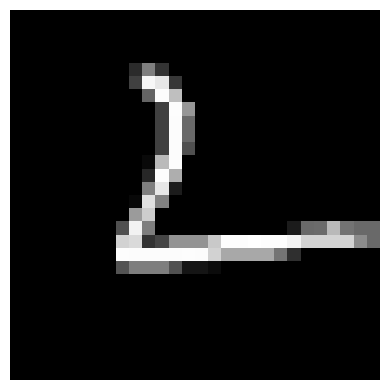

True Class: 2
BNN Prediction: 2
ANN Prediction: 2

BNN Probabilities:
  Class 0: 0.071465
  Class 1: 0.000475
  Class 2: 0.688233
  Class 3: 0.022008
  Class 4: 0.000022
  Class 5: 0.002883
  Class 6: 0.000965
  Class 7: 0.200226
  Class 8: 0.009394
  Class 9: 0.004329

ANN Probabilities:
  Class 0: 0.000000
  Class 1: 0.000000
  Class 2: 0.999986
  Class 3: 0.000010
  Class 4: 0.000000
  Class 5: 0.000004
  Class 6: 0.000000
  Class 7: 0.000000
  Class 8: 0.000000
  Class 9: 0.000000

BNN Epistemic Uncertainty: 0.402241
BNN Aleatoric Uncertainty: 0.141937
BNN Total Uncertainty: 0.426549


In [45]:
def plot_second_highest_epistemic_uncertainty_correct_example(results_bnn, results_ann, X_test, y_test, scaler):
    """
    Plot the correct classification where the BNN has the second-highest epistemic uncertainty.

    Parameters:
        results_bnn: Dictionary containing results from the Bayesian Neural Network.
        results_ann: Dictionary containing results from the classical neural network.
        X_test: Test set features.
        y_test: One-hot encoded test set labels.
        scaler: Scaler used to normalize the images, for inverse scaling.
    """
    # Extract data from the BNN results
    predicted_classes_bnn = results_bnn["predicted_classes"]
    mean_probabilities_bnn = results_bnn["mean_probabilities"]
    epistemic_uncertainty = results_bnn["epistemic_uncertainity"]
    aleatoric_uncertainty = results_bnn["aleatoric_uncertainity"]

    # Extract data from the ANN results
    predicted_classes_ann = results_ann["predicted_classes"]
    mean_probabilities_ann = results_ann["mean_probabilities"]

    # Convert true labels to class indices
    true_classes = np.argmax(y_test, axis=1)

    # Find correct indices
    correct_indices = np.where(predicted_classes_bnn == true_classes)[0]

    # Check if there are any correct examples
    if len(correct_indices) == 0:
        print("No correct examples found.")
        return

    # Find the correct example with the second-highest epistemic uncertainty
    correct_epistemic_uncertainty = epistemic_uncertainty[correct_indices, true_classes[correct_indices]]
    sorted_indices = np.argsort(correct_epistemic_uncertainty)[::-1]  # Sort in descending order
    second_highest_uncert_idx = correct_indices[sorted_indices[3]]  # Take the second-highest

    # Inverse scale the image
    second_highest_uncert_image = scaler.inverse_transform(X_test[second_highest_uncert_idx].reshape(1, -1)).reshape(28, 28)

    # Get details for the selected example
    true_class = true_classes[second_highest_uncert_idx]
    pred_class_bnn = predicted_classes_bnn[second_highest_uncert_idx]
    pred_class_ann = predicted_classes_ann[second_highest_uncert_idx]
    probabilities_bnn = mean_probabilities_bnn[second_highest_uncert_idx]
    probabilities_ann = mean_probabilities_ann[second_highest_uncert_idx]
    epistemic_uncert = epistemic_uncertainty[second_highest_uncert_idx, pred_class_bnn]
    aleatoric_uncert = aleatoric_uncertainty[second_highest_uncert_idx, pred_class_bnn]
    total_uncert = np.sqrt(epistemic_uncert**2 + aleatoric_uncert**2)

    # Plot the correct example
    plt.figure(figsize=(4, 4))
    plt.imshow(second_highest_uncert_image, cmap="gray")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Print details below the image
    print(f"True Class: {true_class}")
    print(f"BNN Prediction: {pred_class_bnn}")
    print(f"ANN Prediction: {pred_class_ann}")
    print("\nBNN Probabilities:")
    for i, prob in enumerate(probabilities_bnn):
        print(f"  Class {i}: {prob:.6f}")
    print("\nANN Probabilities:")
    for i, prob in enumerate(probabilities_ann):
        print(f"  Class {i}: {prob:.6f}")
    print(f"\nBNN Epistemic Uncertainty: {epistemic_uncert:.6f}")
    print(f"BNN Aleatoric Uncertainty: {aleatoric_uncert:.6f}")
    print(f"BNN Total Uncertainty: {total_uncert:.6f}")


plot_second_highest_epistemic_uncertainty_correct_example(results_bnn, results_ann, X_test, y_test, scaler)

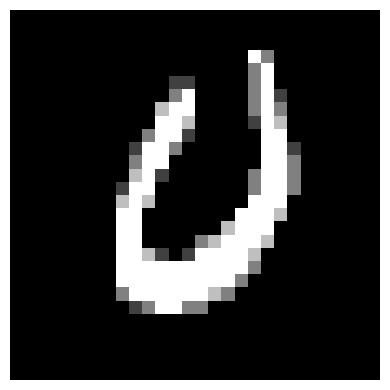

True Class: 0
BNN Prediction: 0
ANN Prediction: 0

BNN Probabilities:
  Class 0: 0.661711
  Class 1: 0.000085
  Class 2: 0.069630
  Class 3: 0.001229
  Class 4: 0.035615
  Class 5: 0.001944
  Class 6: 0.218359
  Class 7: 0.001981
  Class 8: 0.002002
  Class 9: 0.007445

ANN Probabilities:
  Class 0: 0.863349
  Class 1: 0.000096
  Class 2: 0.014374
  Class 3: 0.001605
  Class 4: 0.016355
  Class 5: 0.002208
  Class 6: 0.091618
  Class 7: 0.000972
  Class 8: 0.001121
  Class 9: 0.008302

BNN Epistemic Uncertainty: 0.203444
BNN Aleatoric Uncertainty: 0.268606
BNN Total Uncertainty: 0.336955


In [49]:
def plot_second_highest_aleatoric_uncertainty_correct_example(results_bnn, results_ann, X_test, y_test, scaler):
    """
    Plot the correct classification where the BNN has the second-highest aleatoric uncertainty.

    Parameters:
        results_bnn: Dictionary containing results from the Bayesian Neural Network.
        results_ann: Dictionary containing results from the classical neural network.
        X_test: Test set features.
        y_test: One-hot encoded test set labels.
        scaler: Scaler used to normalize the images, for inverse scaling.
    """
    # Extract data from the BNN results
    predicted_classes_bnn = results_bnn["predicted_classes"]
    mean_probabilities_bnn = results_bnn["mean_probabilities"]
    epistemic_uncertainty = results_bnn["epistemic_uncertainity"]
    aleatoric_uncertainty = results_bnn["aleatoric_uncertainity"]

    # Extract data from the ANN results
    predicted_classes_ann = results_ann["predicted_classes"]
    mean_probabilities_ann = results_ann["mean_probabilities"]

    # Convert true labels to class indices
    true_classes = np.argmax(y_test, axis=1)

    # Find correct indices
    correct_indices = np.where(predicted_classes_bnn == true_classes)[0]

    # Check if there are any correct examples
    if len(correct_indices) == 0:
        print("No correct examples found.")
        return

    # Find the correct example with the second-highest aleatoric uncertainty
    correct_aleatoric_uncertainty = aleatoric_uncertainty[correct_indices, true_classes[correct_indices]]
    sorted_indices = np.argsort(correct_aleatoric_uncertainty)[::-1]  # Sort in descending order
    second_highest_uncert_idx = correct_indices[sorted_indices[5]]  # Take the second-highest

    # Inverse scale the image
    second_highest_uncert_image = scaler.inverse_transform(X_test[second_highest_uncert_idx].reshape(1, -1)).reshape(28, 28)

    # Get details for the selected example
    true_class = true_classes[second_highest_uncert_idx]
    pred_class_bnn = predicted_classes_bnn[second_highest_uncert_idx]
    pred_class_ann = predicted_classes_ann[second_highest_uncert_idx]
    probabilities_bnn = mean_probabilities_bnn[second_highest_uncert_idx]
    probabilities_ann = mean_probabilities_ann[second_highest_uncert_idx]
    epistemic_uncert = epistemic_uncertainty[second_highest_uncert_idx, pred_class_bnn]
    aleatoric_uncert = aleatoric_uncertainty[second_highest_uncert_idx, pred_class_bnn]
    total_uncert = np.sqrt(epistemic_uncert**2 + aleatoric_uncert**2)

    # Plot the correct example
    plt.figure(figsize=(4, 4))
    plt.imshow(second_highest_uncert_image, cmap="gray")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Print details below the image
    print(f"True Class: {true_class}")
    print(f"BNN Prediction: {pred_class_bnn}")
    print(f"ANN Prediction: {pred_class_ann}")
    print("\nBNN Probabilities:")
    for i, prob in enumerate(probabilities_bnn):
        print(f"  Class {i}: {prob:.6f}")
    print("\nANN Probabilities:")
    for i, prob in enumerate(probabilities_ann):
        print(f"  Class {i}: {prob:.6f}")
    print(f"\nBNN Epistemic Uncertainty: {epistemic_uncert:.6f}")
    print(f"BNN Aleatoric Uncertainty: {aleatoric_uncert:.6f}")
    print(f"BNN Total Uncertainty: {total_uncert:.6f}")

plot_second_highest_aleatoric_uncertainty_correct_example(results_bnn, results_ann, X_test, y_test, scaler)

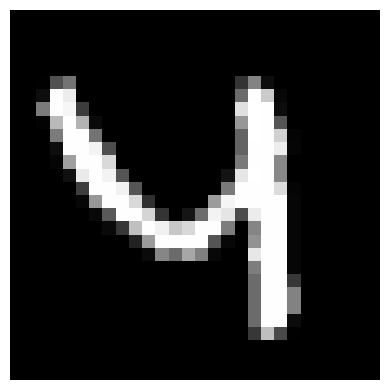

True Class: 4
BNN Prediction: 4
ANN Prediction: 2

BNN Probabilities:
  Class 0: 0.000690
  Class 1: 0.076962
  Class 2: 0.150182
  Class 3: 0.026458
  Class 4: 0.425583
  Class 5: 0.000461
  Class 6: 0.000704
  Class 7: 0.292816
  Class 8: 0.006291
  Class 9: 0.019853

ANN Probabilities:
  Class 0: 0.000100
  Class 1: 0.004030
  Class 2: 0.596713
  Class 3: 0.008160
  Class 4: 0.376067
  Class 5: 0.000189
  Class 6: 0.000257
  Class 7: 0.013698
  Class 8: 0.000099
  Class 9: 0.000686

BNN Epistemic Uncertainty: 0.395160
BNN Aleatoric Uncertainty: 0.188362
BNN Total Uncertainty: 0.437757


In [39]:
def plot_second_highest_total_uncertainty_correct_example(results_bnn, results_ann, X_test, y_test, scaler):
    """
    Plot the correct classification where the BNN has the second-highest total uncertainty.

    Parameters:
        results_bnn: Dictionary containing results from the Bayesian Neural Network.
        results_ann: Dictionary containing results from the classical neural network.
        X_test: Test set features.
        y_test: One-hot encoded test set labels.
        scaler: Scaler used to normalize the images, for inverse scaling.
    """
    # Extract data from the BNN results
    predicted_classes_bnn = results_bnn["predicted_classes"]
    mean_probabilities_bnn = results_bnn["mean_probabilities"]
    epistemic_uncertainty = results_bnn["epistemic_uncertainity"]
    aleatoric_uncertainty = results_bnn["aleatoric_uncertainity"]

    # Extract data from the ANN results
    predicted_classes_ann = results_ann["predicted_classes"]
    mean_probabilities_ann = results_ann["mean_probabilities"]

    # Convert true labels to class indices
    true_classes = np.argmax(y_test, axis=1)

    # Find correct indices
    correct_indices = np.where(predicted_classes_bnn == true_classes)[0]

    # Check if there are any correct examples
    if len(correct_indices) == 0:
        print("No correct examples found.")
        return

    # Compute total uncertainty for all correct examples
    correct_epistemic_uncertainty = epistemic_uncertainty[correct_indices, true_classes[correct_indices]]
    correct_aleatoric_uncertainty = aleatoric_uncertainty[correct_indices, true_classes[correct_indices]]
    total_uncertainty = np.sqrt(correct_epistemic_uncertainty**2 + correct_aleatoric_uncertainty**2)

    # Find the index of the second-highest total uncertainty
    sorted_indices = np.argsort(total_uncertainty)[::-1]  # Sort in descending order
    second_highest_uncert_idx = correct_indices[sorted_indices[4]]  # Take the second-highest

    # Inverse scale the image
    second_highest_uncert_image = scaler.inverse_transform(X_test[second_highest_uncert_idx].reshape(1, -1)).reshape(28, 28)

    # Get details for the selected example
    true_class = true_classes[second_highest_uncert_idx]
    pred_class_bnn = predicted_classes_bnn[second_highest_uncert_idx]
    pred_class_ann = predicted_classes_ann[second_highest_uncert_idx]
    probabilities_bnn = mean_probabilities_bnn[second_highest_uncert_idx]
    probabilities_ann = mean_probabilities_ann[second_highest_uncert_idx]
    epistemic_uncert = epistemic_uncertainty[second_highest_uncert_idx, pred_class_bnn]
    aleatoric_uncert = aleatoric_uncertainty[second_highest_uncert_idx, pred_class_bnn]
    total_uncert = np.sqrt(epistemic_uncert**2 + aleatoric_uncert**2)

    # Plot the correct example
    plt.figure(figsize=(4, 4))
    plt.imshow(second_highest_uncert_image, cmap="gray")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Print details below the image
    print(f"True Class: {true_class}")
    print(f"BNN Prediction: {pred_class_bnn}")
    print(f"ANN Prediction: {pred_class_ann}")
    print("\nBNN Probabilities:")
    for i, prob in enumerate(probabilities_bnn):
        print(f"  Class {i}: {prob:.6f}")
    print("\nANN Probabilities:")
    for i, prob in enumerate(probabilities_ann):
        print(f"  Class {i}: {prob:.6f}")
    print(f"\nBNN Epistemic Uncertainty: {epistemic_uncert:.6f}")
    print(f"BNN Aleatoric Uncertainty: {aleatoric_uncert:.6f}")
    print(f"BNN Total Uncertainty: {total_uncert:.6f}")

# Usage
plot_second_highest_total_uncertainty_correct_example(results_bnn, results_ann, X_test, y_test, scaler)


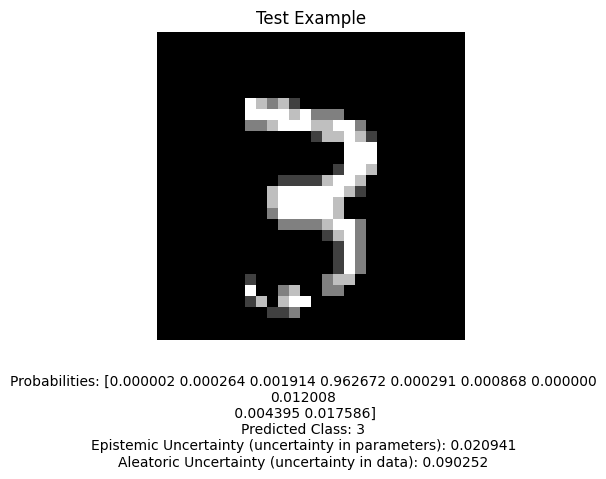

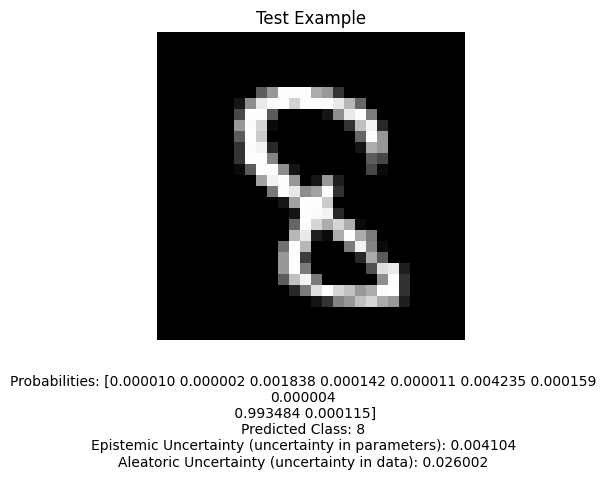

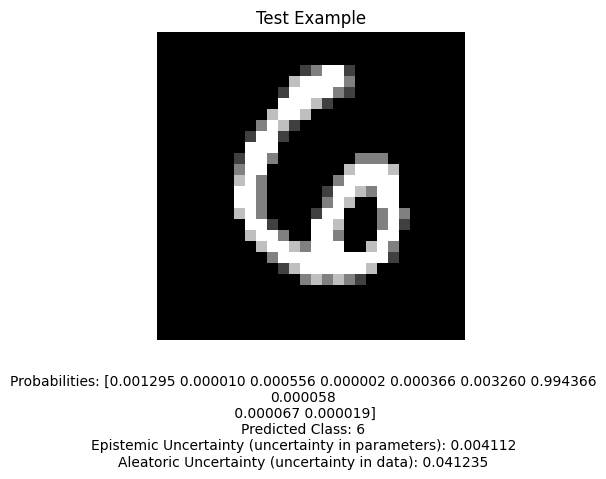

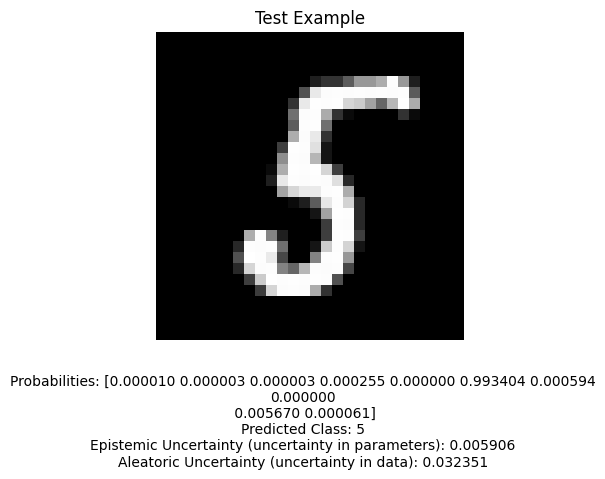

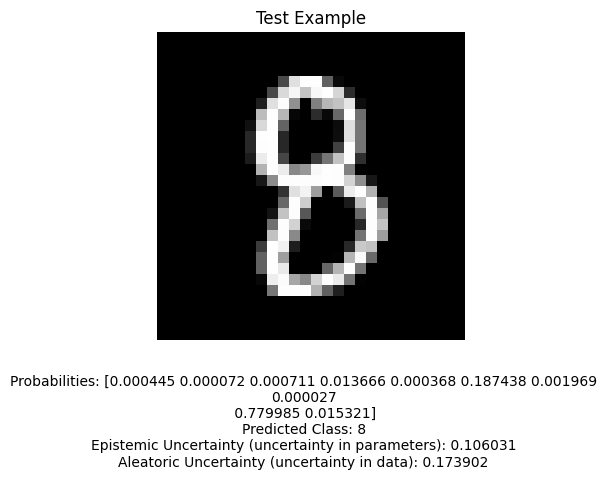

In [89]:
def visualize_predictions(results, X_test, y_test, scaler, num_examples=5):
    # Extract relevant data from the results dictionary
    mean_probabilities = results["mean_probabilities"]
    predicted_classes = results["predicted_classes"]
    epistemic_uncertainty = results["epistemic_uncertainity"]
    aleatoric_uncertainty = results["aleatoric_uncertainity"]

    # Randomly select `num_examples` indices from the test set
    indices = np.random.choice(X_test.shape[0], size=num_examples, replace=False)

    for idx in indices:
        # Inverse scale the image
        original_image = scaler.inverse_transform(X_test[idx].reshape(1, -1)).reshape(28, 28)

        # Retrieve relevant predictions and uncertainties
        probabilities = mean_probabilities[idx]
        predicted_class = predicted_classes[idx]
        epistemic_uncertainty_pred_class = epistemic_uncertainty[idx, predicted_class]
        aleatoric_uncertainty_pred_class = aleatoric_uncertainty[idx, predicted_class]

        # Convert probabilities and uncertainties to float format with 6-7 decimal places
        probabilities_str = np.array2string(probabilities, formatter={'float_kind': lambda x: f"{x:.6f}"})
        epistemic_uncertainty_pred_class_str = f"{epistemic_uncertainty_pred_class:.6f}"
        aleatoric_uncertainty_pred_class_str = f"{aleatoric_uncertainty_pred_class:.6f}"

        # Plot the image
        plt.figure(figsize=(6, 4))
        plt.imshow(original_image, cmap="gray")
        plt.axis("off")
        plt.title("Test Example")

        # Print predictions and uncertainties below the image
        plt.figtext(
            0.5, -0.2,
            f"Probabilities: {probabilities_str}\n"
            f"Predicted Class: {predicted_class}\n"
            f"Epistemic Uncertainty (uncertainty in parameters): {epistemic_uncertainty_pred_class_str}\n"
            f"Aleatoric Uncertainty (uncertainty in data): {aleatoric_uncertainty_pred_class_str}",
            wrap=True, horizontalalignment="center", fontsize=10
        )

        plt.show()

# Use the function to visualize results
visualize_predictions(results, X_test, y_test, scaler, num_examples=5)